# Fit polynomials 1
> Stay fit with polynomials plus a tour through named matrices.

In [2]:
#hide
import numpy as np
import matplotlib.pyplot as plot
from numpy.random import default_rng
from sklearn.datasets import load_diabetes
import math

## Introduction

Fitting with polynomials is the natural step-up from linear regression: fitting with a line. This article is on interpolating series and functions with polynomials, both exact and approximately. 

What started as a small idea to generate a moving image of a polynomial chasing random points has evolved in a tour through nice mathematics. There is both code and mathematics so pick whatever suits you. I hope you enjoy it!

We start with defining the problem and some notation. No worries, we also add graphs to make the problem explicit.

### Example inputs

We can either be given some points $p_1,...,p_n$ or be given a function $f()$ that we want to approximate. I use these interchangably, because a function is convenient as ground truth and to  approximate a function we will be sampling from that function.

To make it concrete lets use some functions and sample 5 points $x_1,...,x_5$ from $[-1, +1]$. Additionally, we use the diabetes dataset from SciKit.

In [3]:
# I pick an odd number since linspace then also includes 0 (the middle value)
d = np.linspace(-1, 1, 101)
x = np.linspace(-1, 1, 5)

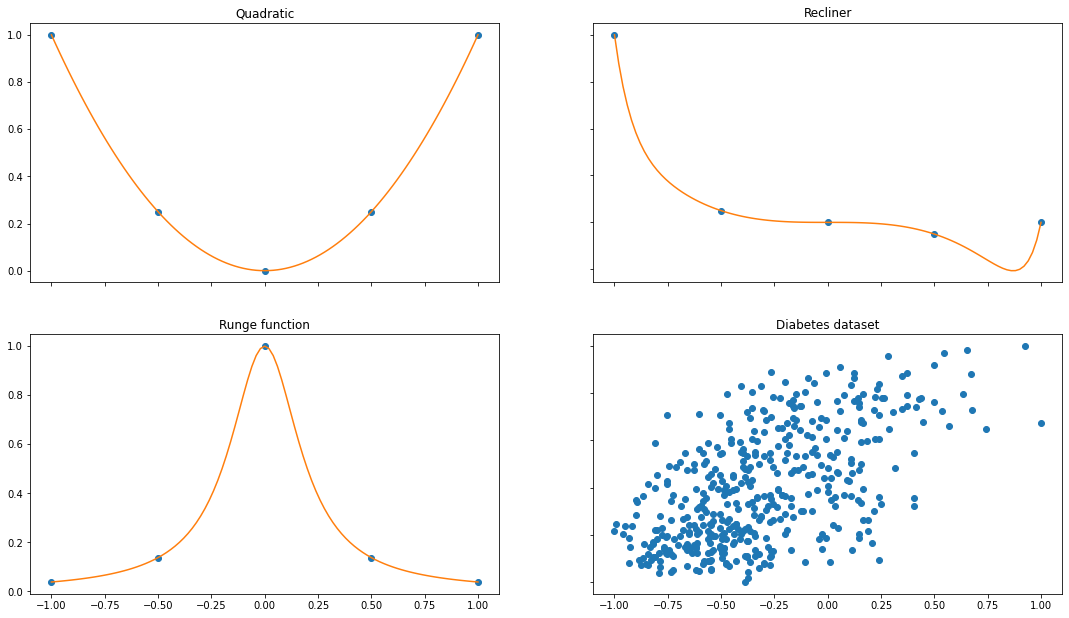

In [4]:
#collapse
fig, axs = plot.subplots(2, 2)
fig.set_size_inches(18.5, 10.5)

f = lambda x: x**2
axs[0, 0].plot(x, f(x), 'o')
axs[0, 0].plot(d, f(d), '-')
axs[0, 0].set_title('Quadratic')

g = lambda x: 1/(1+(5*x)**2)
axs[1, 0].plot(x, g(x), 'o')
axs[1, 0].plot(d, g(d), '-')
axs[1, 0].set_title('Runge function')

h = lambda x: x**14-x**3
axs[0, 1].plot(x, h(x), 'o')
axs[0, 1].plot(d, h(d), '-')
axs[0, 1].set_title('Recliner')

DX, y = load_diabetes(return_X_y=True)
dx = DX[:,2] 
# Map to [-1,1]
dx = (dx - min(dx)) / (max(dx) - min(dx)) * 2 -1
y = (y - min(y)) / (max(y) - min(y))

axs[1, 1].plot(dx, y, 'o')
axs[1, 1].set_title('Diabetes dataset')

for ax in axs.flat:
    ax.label_outer()

# Interpolation vs fit

The goal is to recover the ground truth, given the samples. As can be seen in the examples this is possible for the first few examples, but for the diabetes example there are multiple values for the same $x$. Let's make it concrete what we're trying to do.

We are given points $x_1,...,x_n$ and values $y_1,...,y_n$ and we want to select a polynomial function $p(x)$ of degree $k$:

$$ p_k(x) = c_0 x^0 + c_1 x^1 + ... + c_k x^k $$

For _interpolation_ we want that $p(x_i)=y_i$ for $i=1,...n$.

For _approximation_ we want  to find a polynomial that approximates the value. For this we take the $L_2$ or squared difference distance:

$$ \min_{p_k(x)}  \sum_i ( y_i - p_k(x_i) )^2 = \min_{p_k(x)}  ||  y_i - p_k(x_i) ||_2 $$

# Interpolation of a polynomial with monomials

For $n$ points there exists a unique polynomial of degree $n-1$ that passes through these points. To find this polynomial we can solve a linear system of $n$ equations with $n$ variables. 

## Example for n=2
As an example take the points $(-0.5,0.25), (0, 0), (0.5, 0.25)$ and we want to find a quadratic polynomial $p(x) = c_0 + c_1 \cdot x + c_2 \cdot x^2$.

The linear equations will be
$$p(-0.5) = 0.25  = c_0 + c_1 \cdot -0.5 + c_2 \cdot (-0.5)^2 $$
$$p(0) = 0 = c_0 + c_1 \cdot 0. + c_2 \cdot 0^2 $$
$$p(0.5) = 0.25  = c_0 + c_1 \cdot 0.5 + c_2 \cdot (0.5)^2 $$


For this example we can solve by hand by noting that $c_0=0$ (second equation), which leaves
$$ 0.25 = -c_1/2 + c_2/4 $$
$$ 0.25  = c_1/2 + c_2/4 $$

and thus $c_1=0$ and $c_2=1$.

This is a good thing since I picked the points from the function $f(x) = x^2$ :).

## Matrix notation

It is convenient to write the equations above in matrix form and make the _coefficients_ $c$  explicit. In the optimization we keep degree $k$ fixed, but have to pick the best $c$.

We can do this in matrix form and state $A_k(x)c=y$, where $A_k(x)$ is the matrix for the values $x$ and the powers up to $k$ (the _monomials_):

For $k=2$ it would be 

$$A_2(x) = 
\begin{bmatrix}
1 & -.5 & .25 \\
1 & 0 & 0 \\
1 & .5 & .25 \\
\end{bmatrix}
$$


For approximation we would write

$$ min_c ||y - A_k(x)c||_2 $$

The matrix of the _monomials_ is called the Vandermonde matrix. Using the functionality in NumPy gives the same matrix as above (but for two extra points):

In [22]:
np.vander(x, 3, increasing=True)

array([[ 1.  , -1.  ,  1.  ],
       [ 1.  , -0.5 ,  0.25],
       [ 1.  ,  0.  ,  0.  ],
       [ 1.  ,  0.5 ,  0.25],
       [ 1.  ,  1.  ,  1.  ]])

## General

Equiped with matrix notation we solve $Ac=y$ for $c$. For example by taking the inverse $A^{-1}y=c$. 

In [23]:
A = np.array([[1, -1/2, 1/4], [1, 0, 0], [1, 1/2, 1/4]])
y = np.array([0.25, 0., 0.25])
c = np.linalg.inv(A) @ y
c

array([0., 0., 1.])

We can do the same programmatically for the Runge function and degree $4$

In [24]:
#collapse
def interpolate(f, x):
    M = np.vander(x, increasing=True)
    c = np.linalg.inv(M) @ f(x)
    return c

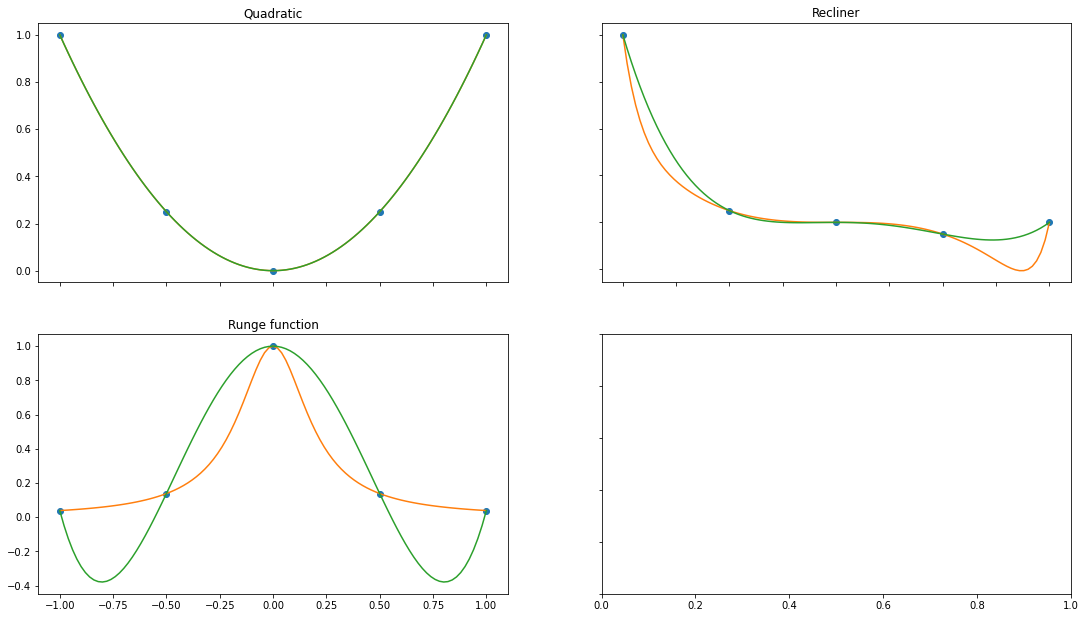

In [25]:
#collapse
fig, axs = plot.subplots(2, 2)
fig.set_size_inches(18.5, 10.5)

f = lambda x: x**2
pf  = np.polynomial.Polynomial(interpolate(f,x))
axs[0, 0].plot(x, f(x), 'o')
axs[0, 0].plot(d, f(d), '-')
axs[0, 0].plot(d, pf(d), '-')
axs[0, 0].set_title('Quadratic')

g = lambda x: 1/(1+(5*x)**2)
pg  = np.polynomial.Polynomial(interpolate(g,x))
axs[1, 0].plot(x, g(x), 'o')
axs[1, 0].plot(d, g(d), '-')
axs[1, 0].plot(d, pg(d), '-')
axs[1, 0].set_title('Runge function')

h = lambda x: x**14-x**3
ph  = np.polynomial.Polynomial(interpolate(h,x))
axs[0, 1].plot(x, h(x), 'o')
axs[0, 1].plot(d, h(d), '-')
axs[0, 1].plot(d, ph(d), '-')
axs[0, 1].set_title('Recliner')


for ax in axs.flat:
    ax.label_outer()

# Approximation 

What if we wanted to approximate with a lower degree polynomial than the number of points? For this we can use the Moore-Penrose inverse, a generalization of the normal matrix inverse $A A^{-1} = I$

The Moore-Penrose inverse (Denoted as $A^+$) can be defined in terms of solving a linear system of equations $Ac=y$. The solution to $A^+y = \hat{c}$ is the least squares solution i.e. $||Ac-y||_2 \geq ||A\hat{c}-y||_2, \forall c$.

With this result we can approximate 

In [26]:
def approximate(y, x, d=3):
    A = np.vander(x, N=d, increasing=True)
    c_approx = np.linalg.pinv(A) @ y
    return c_approx

A good question, that I do not know the answer too, is how the numerical instability (condition number) of the Moore-Penrose inversion relations to the regular inversion. If you know: please tell me.

Alternatively we can find the 'best' solution to $Ac=y$ with `np.linalg.lstsq`.

In [28]:
def approximate(y, x, d=3):
    A = np.vander(x, N=d, increasing=True)
    c, _, _, _ = np.linalg.lstsq(A, y, rcond=None)
    return c

With degree 2:

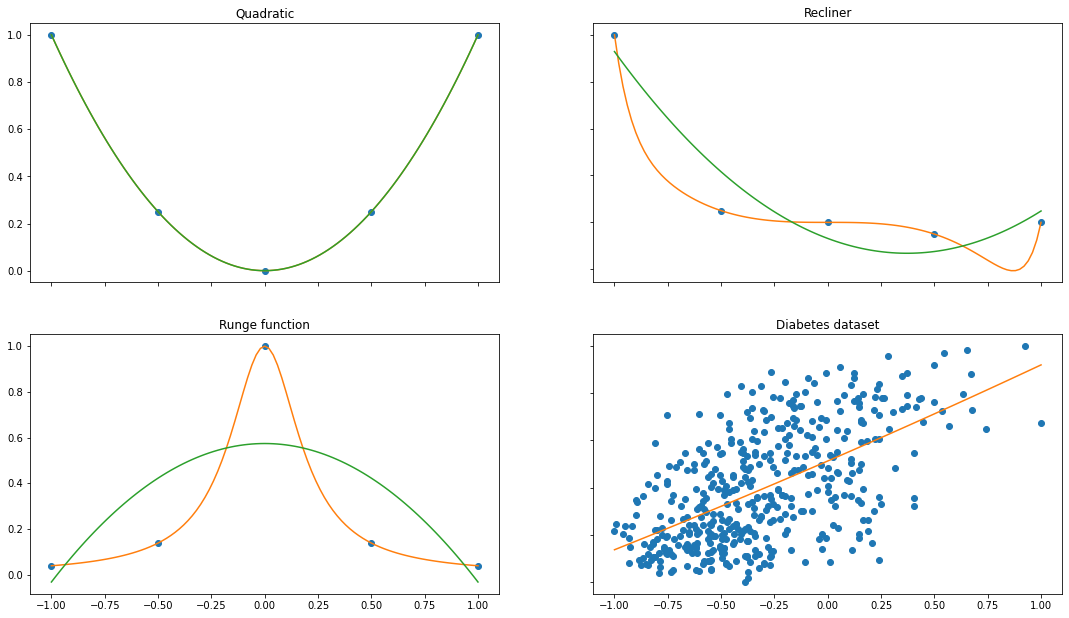

In [30]:
#collapse
degree = 3
fig, axs = plot.subplots(2, 2)
fig.set_size_inches(18.5, 10.5)

f = lambda x: x**2
pf  = np.polynomial.Polynomial(approximate(f(x),x, d=degree))
axs[0, 0].plot(x, f(x), 'o')
axs[0, 0].plot(d, f(d), '-')
axs[0, 0].plot(d, pf(d), '-')
axs[0, 0].set_title('Quadratic')

g = lambda x: 1/(1+(5*x)**2)
pg  = np.polynomial.Polynomial(approximate(g(x),x, d=degree))
axs[1, 0].plot(x, g(x), 'o')
axs[1, 0].plot(d, g(d), '-')
axs[1, 0].plot(d, pg(d), '-')
axs[1, 0].set_title('Runge function')

h = lambda x: x**14-x**3
ph  = np.polynomial.Polynomial(approximate(h(x),x, d=degree))
axs[0, 1].plot(x, h(x), 'o')
axs[0, 1].plot(d, h(d), '-')
axs[0, 1].plot(d, ph(d), '-')
axs[0, 1].set_title('Recliner')

DX, y = load_diabetes(return_X_y=True)
dx = DX[:,2] 
# Map to [-1,1]
dx = (dx - min(dx)) / (max(dx) - min(dx)) * 2 -1
y = (y - min(y)) / (max(y) - min(y))
pd = np.polynomial.Polynomial(approximate(y,dx,d=degree))

axs[1, 1].plot(dx, y, 'o')
axs[1, 1].plot(d, pd(d), '-')
axs[1, 1].set_title('Diabetes dataset')

for ax in axs.flat:
    ax.label_outer()

With degree 14:

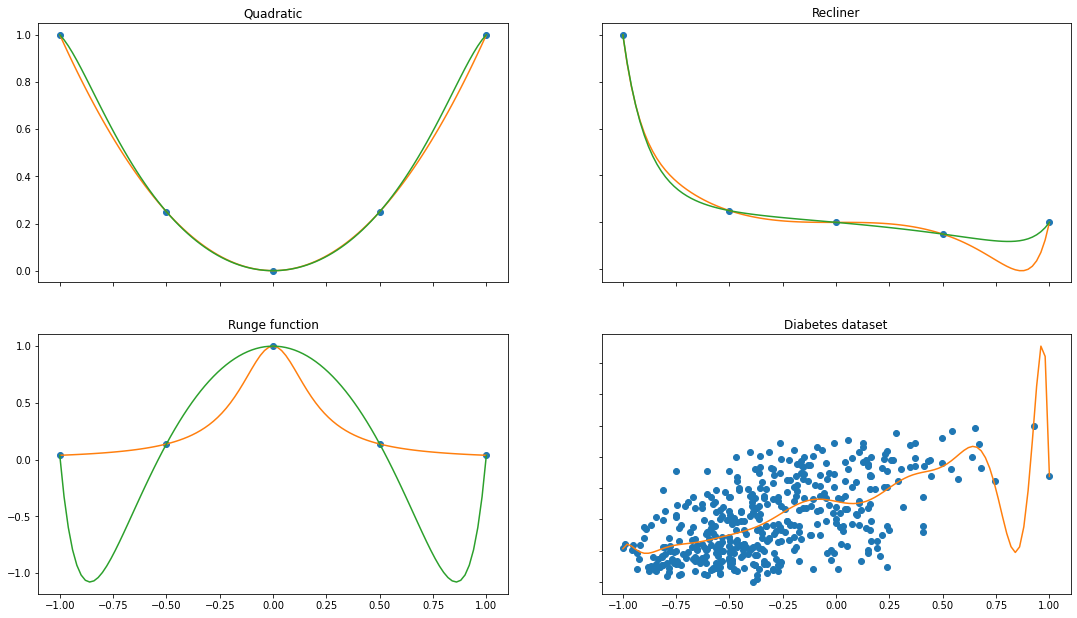

In [31]:
#collapse
degree = 15
fig, axs = plot.subplots(2, 2)
fig.set_size_inches(18.5, 10.5)

f = lambda x: x**2
pf  = np.polynomial.Polynomial(approximate(f(x),x, d=degree))
axs[0, 0].plot(x, f(x), 'o')
axs[0, 0].plot(d, f(d), '-')
axs[0, 0].plot(d, pf(d), '-')
axs[0, 0].set_title('Quadratic')

g = lambda x: 1/(1+(5*x)**2)
pg  = np.polynomial.Polynomial(approximate(g(x),x, d=degree))
axs[1, 0].plot(x, g(x), 'o')
axs[1, 0].plot(d, g(d), '-')
axs[1, 0].plot(d, pg(d), '-')
axs[1, 0].set_title('Runge function')

h = lambda x: x**14-x**3
ph  = np.polynomial.Polynomial(approximate(h(x),x, d=degree))
axs[0, 1].plot(x, h(x), 'o')
axs[0, 1].plot(d, h(d), '-')
axs[0, 1].plot(d, ph(d), '-')
axs[0, 1].set_title('Recliner')

DX, y = load_diabetes(return_X_y=True)
dx = DX[:,2] 
# Map to [-1,1]
dx = (dx - min(dx)) / (max(dx) - min(dx)) * 2 -1
y = (y - min(y)) / (max(y) - min(y))
pd = np.polynomial.Polynomial(approximate(y,dx,d=degree))

axs[1, 1].plot(dx, y, 'o')
axs[1, 1].plot(d, pd(d), '-')
axs[1, 1].set_title('Diabetes dataset')

for ax in axs.flat:
    ax.label_outer()

Note the beautiful overfitting on the diabetest dataset and how bad the Runge function is approximated. This post will be following by some other posts about:

* Interpolation with Lagrange polynomials and derivatives
* Solve $\geq$ invert

Hope you enjoyed it thusfar.